<a href="https://colab.research.google.com/github/wanwanliang/ML_Practices/blob/main/Classification_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
os.chdir("/content/drive/My Drive/ML/handson/")

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST Dataset 

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [ ]:
type(X)

numpy.ndarray

In [ ]:
sp = X[2]
sp_img = sp.reshape(28,28)

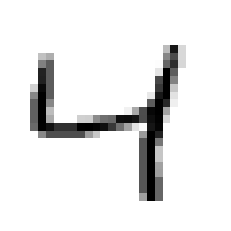

In [ ]:
plt.imshow(sp_img, cmap= mpl.cm.binary)
plt.axis('off')
plt.show()

In [ ]:
print(y[2])

4


In [ ]:
y = y.astype(np.uint8)
print(y[2])

4


## Define Plot Functions

In [ ]:
def plot_digit(data):
  img = data.reshape(28,28)
  plt.imshow(img, cmap = mpl.cm.binary, interpolation='nearest')
  plt.axis('off')

In [ ]:
def multi_plot(images, size=28, img_per_row=10):
  img_per_row = min(img_per_row, len(images))

  nrow = len(images)//img_per_row +1
  n_empty = nrow*img_per_row - len(images)

  images_re = [image.reshape(size, size) for image in images]
  images_re.append(np.zeros((size,size*n_empty)))
  row_images = []

  for row in range(nrow):
    rimage = images_re[row*img_per_row:(row+1)*img_per_row]
    row_images.append(np.concatenate(rimage, axis=1))
  
  all_images = np.concatenate(row_images, axis=0)

  plt.imshow(all_images, cmap=mpl.cm.binary)
  plt.axis('off')

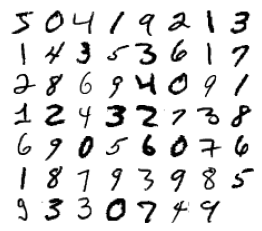

In [ ]:
multi_plot(X[:55], size=28, img_per_row=8)

In [ ]:
len(X)

70000

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

In [ ]:
print(type(y_train))
print(type(X))

print(X.shape)
print(y.shape)

print(y[1])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(70000, 784)
(70000,)
0


In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print(len(y_train_5))
print(len(y_test_5))

print(y_train_5[:5])
print(y_test_5[:5])

60000
10000
[ True False False False False]
[False False False False False]


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([X[4920]])

array([False])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, n_jobs=5, scoring='accuracy')

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, n_jobs=3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds, X_test_fold = X_train[train_index], X_train[test_index]
  y_train_folds, y_test_fold = y_train_5[train_index], y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=3)

confusion_matrix(y_train_pred, y_train_5)

array([[53892,  1891],
       [  687,  3530]])

In [ ]:
from sklearn.metrics import precision_recall_curve

y_train_pred_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_pred_score)

In [ ]:
print(len(precisions))
print(len(recalls))
print(len(thresholds))

59967
59967
59966


In [ ]:
print(type(y_train_pred_score))
y_train_pred_score[:5]

<class 'numpy.ndarray'>


array([  1200.93051237, -26883.79202424, -33072.03475406, -15919.5480689 ,
       -20003.53970191])

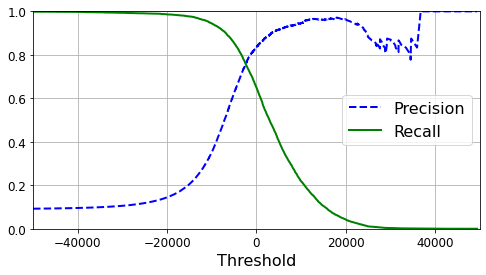

In [ ]:
def plot_curve(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
  plt.plot(thresholds, recalls[:-1], 'g-', label="Recall", linewidth=2)
  plt.legend(loc='center right', fontsize=16)
  plt.xlabel("Threshold", fontsize=16)
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

plt.figure(figsize=(8,4))

plot_curve(precisions, recalls, thresholds)


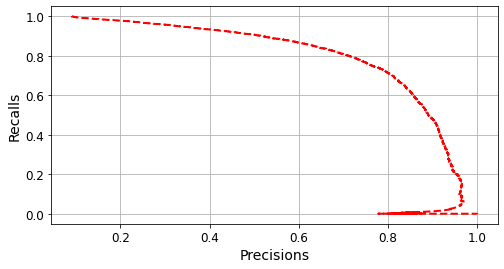

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(precisions, recalls, 'r--', linewidth=2)
plt.xlabel('Precisions', fontsize=14)
plt.ylabel("Recalls", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
x=[-1,0,1,2,3]
x[:-2]

[-1, 0, 1]